In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/notebook_template.ipynb"">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This notebook shows how to pull your data from Feature Store for training, run data exploratory analysis on your data, build a machine learning model locally, experiment with various hyperparameters, evaluate the model and deloy it to a Vertex AI endpoint. 

### Objective

In the following notebook, you will learn how to:

* Use a Feature Store to pull training data
* Do some exploratory analysis on the extracted data
* Train the model and track the results using Vertex Experiments

### Load config settings

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
BUCKET_NAME = PROJECT_ID
config = !gsutil cat gs://{BUCKET_NAME}/config/notebook_env.py
print(config.n)
exec(config.n)


BUCKET_NAME          = "transaction-detective22-1559"
PROJECT              = "transaction-detective22-1559"
REGION               = "us-central1"
SUFFIX               = "aiplatform.googleapis.com"
API_ENDPOINT         = "us-central1-aiplatform.googleapis.com"
PREDICT_API_ENDPOINT = "us-central1-prediction-aiplatform.googleapis.com"
FS_NAME              = "transaction-detective22-1559"
ID                   = "7551"
FEATURESTORE_ID      = "fraud_finder_7551"
TIMESTAMP            = "1647254678"
TRAINING_DS_SIZE     = "1000"



### Select an experiment name

Let us define the experiment name to store . If EXEPERIMENT_NAME is not set, set a default one below:

In [2]:
EXPERIMENT_NAME = ""  # @param {type:"string"}
if EXPERIMENT_NAME == "" or EXPERIMENT_NAME is None:
    EXPERIMENT_NAME = "fd-experiment-" + TIMESTAMP

### Import libraries

In [3]:
#General
import os
import sys
from typing import Union, List
import random

#Data Preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#Model Training
from google.cloud import bigquery
from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform_v1 import ModelServiceClient
from google.cloud.aiplatform_v1.types import ListModelEvaluationsRequest
from google.protobuf.json_format import MessageToDict
from google.cloud.aiplatform import gapic as aip
from google.cloud import storage
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from google.cloud import bigquery
from google.cloud import storage
from sklearn.metrics import classification_report, f1_score, accuracy_score
import json
import logging
import xgboost as xgb

#Feature Store
from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform import Featurestore, EntityType, Feature

### Define constants

In [4]:
# General
DATA_DIR = os.path.join(os.pardir, 'data')
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
DATA_URI = f'gs://{BUCKET_NAME}/data'
TRAIN_DATA_URI = f'{DATA_URI}/train'
CONFIG_URI =  f'gs://{BUCKET_NAME}/config' 
BQ_DATASET = "tx"

#Feature Store
START_DATE_TRAIN = "2022-01-01" #consider few days for training (demo)
END_DATE_TRAIN = "2022-01-31"
EVENTS_TABLE_NAME = f'events_{END_DATE_TRAIN}'
CUSTOMERS_TABLE_NAME = f'customers_{END_DATE_TRAIN}'
TERMINALS_TABLE_NAME = f'terminals_{END_DATE_TRAIN}'
DATA_ENDPOINT = f"{REGION}-featurestore-aiplatform.googleapis.com"
ADMIN_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"
EVENT_ENTITY = 'event'
CUSTOMER_ENTITY = 'customer'
TERMINAL_ENTITY = 'terminal'
SERVING_FEATURE_IDS = {CUSTOMER_ENTITY: ['*'], EVENT_ENTITY: ['*'], TERMINAL_ENTITY: ['*']}

# Training
COLUMNS_IGNORE = ['terminal_id', 'customer_id', 'entity_type_event', 'entity_type_customer', 'entity_type_terminal']
TARGET = 'tx_fraud'

## Custom Training
DATASET_NAME=f"sample_train-{ID}-{END_DATE_TRAIN}"
TRAIN_JOB_NAME=f"fraudfinder_xgb_train_expr-{ID}-{TIMESTAMP}"
MODEL_NAME=f"fraudfinder_xgb_model_expr-{ID}-{TIMESTAMP}"
DEPLOYED_NAME = f"fraudfinder_xgb_prediction_expr-{ID}-{TIMESTAMP}"

### Inizialize clients

In [5]:
bq_client = bigquery.Client(project=PROJECT_ID, location=REGION)

In [6]:
vertex_ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME, experiment=EXPERIMENT_NAME)

INFO:root:MetadataStore default not found.
INFO:root:Resource fd-experiment-1647254678 not found.
INFO:root:Creating Resource fd-experiment-1647254678


### Helpers

In [7]:
def create_gcs_dataset(client,
                       display_name: str, 
                       gcs_source: Union[str, List[str]]):
    
    dataset = client.TabularDataset.create(
        display_name=display_name, gcs_source=gcs_source,
    )

    dataset.wait()
    return dataset
    

def get_evaluation_metrics(client, model_resource_name):
    model_evalution_request = ListModelEvaluationsRequest(parent=model_resource_name)
    model_evaluation_list = client.list_model_evaluations(request=model_evalution_request)
    metrics_strlist = []
    for evaluation in model_evaluation_list:
        metrics = MessageToDict(evaluation._pb.metrics)
    return metrics

def gcs_list(gcs_uri):
    obj_list=[]
    storage_client = storage.Client()
    bucket, key = gcs_uri.replace("gs://", "").split("/", 1)
    for blob in storage_client.list_blobs(bucket, prefix=key):
        obj_list.append("gs://"+bucket+"/"+str(blob.name))
    return obj_list

def preprocess(df):
    """Converts categorical features to numeric. Removes unused columns.

    Args:
      df: Pandas df with raw data

    Returns:
      df with preprocessed data
    """
    df = df.drop(columns=UNUSED_COLUMNS)

    # Drop rows with NaN's
    df = df.dropna()

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = df.select_dtypes(["int32", "float32", "float64"]).columns
    df[numeric_columns] = df[numeric_columns].astype("float32")

    dummy_columns = list(df.dtypes[df.dtypes == 'category'].index)
    df = pd.get_dummies(df, columns=dummy_columns)

    return df

## Fetching feature values for model training

To fetch training data, we have to specify the following inputs to batch serving:

- A file containing a "query", with the entities and timestamps for each label.
- List of features to fetch values for
- Destination location and format


### Read-instance list

In our case, we need a csv file with content formatted like the table below

|event|customer                     |terminal|timestamp                                    |
|-----|-----------------------------|--------|---------------------------------------------|
|xxx57538|xxx3859                         |xxx8811    |2021-07-07 00:01:10 UTC                      |
|xxx57539|xxx4165                         |xxx8810    |2021-07-07 00:01:55 UTC                      |
|xxx57540|xxx2289                         |xxx2081    |2021-07-07 00:02:12 UTC                      |
|xxx57541|xxx3227                         |xxx3011    |2021-07-07 00:03:23 UTC                      |
|xxx57542|xxx2819                         |xxx6263    |2021-07-07 00:05:30 UTC                      |

where column names are the name of entities in Feature Store and the timestamp represents the time of occured event

In [8]:
sql_query = f"""
SELECT
  e.TX_ID AS event,
  e.CUSTOMER_ID AS customer,
  e.TERMINAL_ID AS terminal,
  e.TX_TS AS timestamp
FROM
  `{BQ_DATASET}.{EVENTS_TABLE_NAME}` AS e
WHERE
  e.TX_TS BETWEEN "{START_DATE_TRAIN}" AND "{END_DATE_TRAIN}"
LIMIT {TRAINING_DS_SIZE}
"""

try:
    query_df = bq_client.query(sql_query).to_dataframe()
except RuntimeError as error:
    print(error)
query_df['timestamp'] = pd.to_datetime(query_df.timestamp).dt.tz_convert('UTC').dt.strftime('%Y-%m-%d %H:%M:%S')
query_df['timestamp'] = pd.to_datetime(query_df.timestamp)

In [9]:
query_df.head(5)

,event,customer,terminal,timestamp
0,86463d9c98855bdbd0031740cc81ad8f264389a3,3857320063734266,98049794,2022-01-01 00:00:01
1,f8f95dd43d4a6bbbc4ead9f4e96cde9bc1296cf4,2230658166719498,15873857,2022-01-01 00:00:01
2,cd2a5ff7c07e1d853f39de7f9b0430364b0cc8a3,9855625522226284,62815532,2022-01-01 00:00:08
3,57d7f7306e59c111622d7882635e65a29aa7cae1,1760948274331793,42211721,2022-01-01 00:00:15
4,9d239846a64e376f55ae72e10440a34fb07d94fc,8637593051245921,22176978,2022-01-01 00:00:18


### Get Feature Store

In [11]:
try:
    ff_feature_store = Featurestore(FEATURESTORE_ID)
except NameError:
    print(f"""The feature store {FEATURESTORE_ID} does not exist!""")  

### Export a training sample of data to dataframe

In [12]:
sample_df = ff_feature_store.batch_serve_to_df(
    serving_feature_ids=SERVING_FEATURE_IDS,
    read_instances_df=query_df,
)

INFO:google.cloud.aiplatform.featurestore.featurestore:Serving Featurestore feature values: projects/130114571864/locations/us-central1/featurestores/fraud_finder_7551
INFO:google.cloud.aiplatform.featurestore.featurestore:Serve Featurestore feature values backing LRO: projects/130114571864/locations/us-central1/featurestores/fraud_finder_7551/operations/6626005133127843840
INFO:google.cloud.aiplatform.featurestore.featurestore:Featurestore feature values served. Resource name: projects/130114571864/locations/us-central1/featurestores/fraud_finder_7551


### Data exploration
Here we use a subset of data for data exploration and better underestanding of the data.

In [13]:
sample_df.head()

,timestamp,entity_type_customer,customer_id_nb_tx_14day_window,customer_id_nb_tx_1day_window,customer_id_nb_tx_7day_window,customer_id_avg_amount_14day_window,customer_id_avg_amount_1day_window,customer_id_avg_amount_7day_window,entity_type_event,terminal_id,tx_fraud,tx_amount,customer_id,entity_type_terminal,terminal_id_risk_14day_window,terminal_id_risk_1day_window,terminal_id_risk_7day_window,terminal_id_nb_tx_7day_window,terminal_id_nb_tx_1day_window,terminal_id_nb_tx_14day_window
0,2022-01-01 02:00:07+00:00,5164706087546900,1,1,1,48.98,48.98,48.98,39b6a98a5d7015bbd981db287e1089d73be01e8f,88604826,0,48.98,5164706087546900,88604826,0.0,0.0,0.0,0,0,0
1,2022-01-01 00:08:34+00:00,3379673605030711,1,1,1,4.64,4.64,4.64,e58ad952732f0a07ea6cef8f3faca461126d6a50,10362239,0,4.64,3379673605030711,10362239,0.0,0.0,0.0,0,0,0
2,2022-01-01 01:13:04+00:00,3136339582390781,1,1,1,50.02,50.02,50.02,267b178833cf4caf58ecf0df310d09174eb890c5,16959692,0,50.02,3136339582390781,16959692,0.0,0.0,0.0,0,0,0
3,2022-01-01 01:30:19+00:00,9585841137229882,1,1,1,43.51,43.51,43.51,d1fb78040f5babf87cac43df61f079e19a30f471,93285096,0,43.51,9585841137229882,93285096,0.0,0.0,0.0,0,0,0
4,2022-01-01 00:31:24+00:00,2410534465201092,1,1,1,25.20,25.20,25.20,27e252dc0df22821140c93d21dae18e3cedb4369,16207868,0,25.20,2410534465201092,16207868,0.0,0.0,0.0,0,0,0


In [14]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   timestamp                            1000 non-null   datetime64[ns, UTC]
 1   entity_type_customer                 1000 non-null   object             
 2   customer_id_nb_tx_14day_window       1000 non-null   int64              
 3   customer_id_nb_tx_1day_window        1000 non-null   int64              
 4   customer_id_nb_tx_7day_window        1000 non-null   int64              
 5   customer_id_avg_amount_14day_window  1000 non-null   float64            
 6   customer_id_avg_amount_1day_window   1000 non-null   float64            
 7   customer_id_avg_amount_7day_window   1000 non-null   float64            
 8   entity_type_event                    1000 non-null   object             
 9   terminal_id                    

#### Target

<AxesSubplot:title={'center':'fraud_reported distribution'}, xlabel='tx_fraud', ylabel='count'>

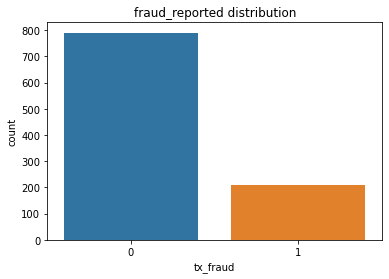

In [15]:
plt.title('fraud_reported distribution')
sns.countplot(x='tx_fraud', data=sample_df)

In [16]:
(sample_df.tx_fraud.value_counts()/sample_df.shape[0])*100

0    79.0
1    21.0
Name: tx_fraud, dtype: float64

As we can see the data is imbalanced. We will fix this later in this notebook before building the model.

#### Features

In [17]:
list(sample_df.columns)

['timestamp',
 'entity_type_customer',
 'customer_id_nb_tx_14day_window',
 'customer_id_nb_tx_1day_window',
 'customer_id_nb_tx_7day_window',
 'customer_id_avg_amount_14day_window',
 'customer_id_avg_amount_1day_window',
 'customer_id_avg_amount_7day_window',
 'entity_type_event',
 'terminal_id',
 'tx_fraud',
 'tx_amount',
 'customer_id',
 'entity_type_terminal',
 'terminal_id_risk_14day_window',
 'terminal_id_risk_1day_window',
 'terminal_id_risk_7day_window',
 'terminal_id_nb_tx_7day_window',
 'terminal_id_nb_tx_1day_window',
 'terminal_id_nb_tx_14day_window']

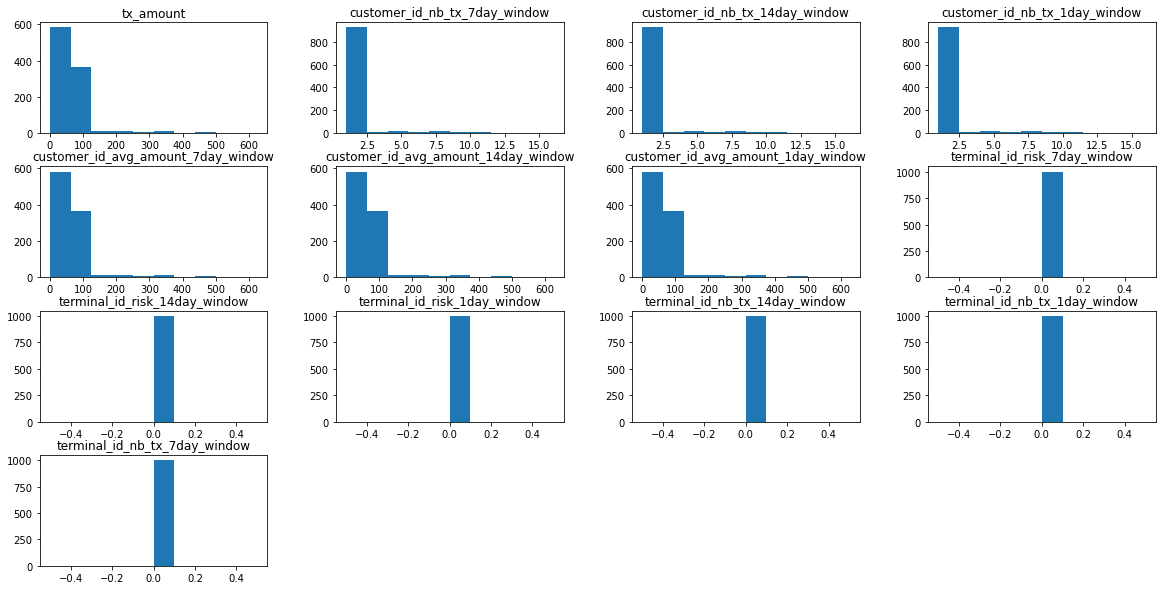

In [18]:
features = [ 'tx_amount', 'customer_id_nb_tx_7day_window', 'customer_id_nb_tx_14day_window',
             'customer_id_nb_tx_1day_window', 'customer_id_avg_amount_7day_window', 'customer_id_avg_amount_14day_window',
             'customer_id_avg_amount_1day_window', 'terminal_id_risk_7day_window', 'terminal_id_risk_14day_window',
             'terminal_id_risk_1day_window', 'terminal_id_nb_tx_14day_window', 'terminal_id_nb_tx_1day_window',
            'terminal_id_nb_tx_7day_window']

sample_df[features].hist(figsize = (20, 10), grid=False);

#### Analyze the relationship between features and ```tx_fraud```

<AxesSubplot:>

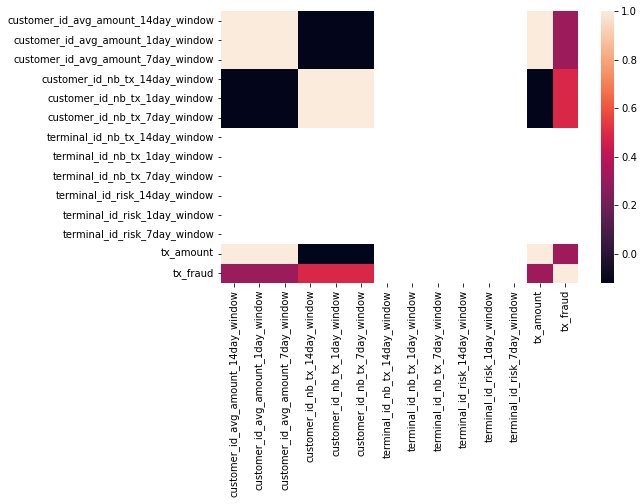

In [19]:
plt.figure(figsize=(8,5))
sns.heatmap(sample_df[sample_df.columns.difference(COLUMNS_IGNORE)].corr())

**Comments**

Based on the EDA of the sample:

- the sample is super unbalanced
- we need to delete some variables
- we could convert timestamp and extract variables such as day week, night, etc (calculate embeddings)
- we could do variable selection
- we need to scale variables

## Builing a custom fraud detection model

### Fixing Imbalanced Dataset
In this section, we will deal with imbalance dataset. Specifically, we will randomly delete some of the instances from the non-fraud class in order to match the numbers with the fraud class. This technique is called undersampling.For this workshop, we will skip the data balance process, as our sample data is very samll. Please uncomment the following cell if you have collected a big sample data.

In [ ]:
# shuffled_df = sample_df.sample(frac=1,random_state=4)
# fraud_df = shuffled_df.loc[shuffled_df['tx_fraud'] == 1]
# non_fraud_df = shuffled_df.loc[shuffled_df['tx_fraud'] == 0].sample(n=fraud_df.shape[0],random_state=42)
# balanced_df = pd.concat([fraud_df, non_fraud_df])
# (balanced_df.tx_fraud.value_counts()/balanced_df.shape[0])*100

### Training
In this section, we will use xgboost algorithm. Typically, to perform training, you will use Vertex AI traning pipeline, however, as we are experimenting, we simply use xgboost package to tranin our model in the notebook. 



#### Preparing datasets
In the follwing cell, we split data into training, test, and validation set:

In [20]:
# Set up training variables
LABEL_COLUMN = "tx_fraud"
UNUSED_COLUMNS = ["timestamp","entity_type_event","terminal_id","customer_id","entity_type_customer","entity_type_terminal"]
NA_VALUES = ["NA", "."]

df_dataset = sample_df
df_train, df_test, df_val = np.split(df_dataset.sample(frac=1, random_state=42), [int(.6*len(df_dataset)), int(.8*len(df_dataset))])

#training set
preprocessed_train_Data = preprocess(df_dataset)
x_train = preprocessed_train_Data[preprocessed_train_Data.columns.drop(LABEL_COLUMN).to_list()].values
y_train = preprocessed_train_Data.loc[:,LABEL_COLUMN].astype(int)

#validation set
preprocessed_val_Data = preprocess(df_val)
x_val = preprocessed_val_Data[preprocessed_val_Data.columns.drop(LABEL_COLUMN).to_list()].values
y_val = preprocessed_val_Data.loc[:,LABEL_COLUMN].astype(int)

#test set
preprocessed_test_Data = preprocess(df_test)
x_test = preprocessed_test_Data[preprocessed_test_Data.columns.drop(LABEL_COLUMN).to_list()].values
y_test = preprocessed_test_Data.loc[:,LABEL_COLUMN].astype(int)

#### Training the model
Before running XGBoost, we can set some hyperparameters. It is one of the key to XGBoost performance. As the best practice, you can use Vertex AI HyperParameter Tuning to automatically find the best parameters. However, in this notebook, for the sake of simplicity, we just specify some of these hyperparemeters manually and randomly to experiment.  
- eta is a regularization parameter to reduce feature weights in each boosting step. 
- gamma is another regularization parameter for tree pruning. 

In [21]:
parameters = [
    {"eta": 0.2, "gamma": 0.0, "max_depth": 4},
    {"eta": 0.2, "gamma": 0.0, "max_depth": 5},
    {"eta": 0.2, "gamma": 0.1, "max_depth": 4},
    {"eta": 0.2, "gamma": 0.1, "max_depth": 5},
    {"eta": 0.3, "gamma": 0.0, "max_depth": 4},
    {"eta": 0.3, "gamma": 0.0, "max_depth": 5},
    {"eta": 0.3, "gamma": 0.1, "max_depth": 4},
    {"eta": 0.3, "gamma": 0.1, "max_depth": 5},
]
models={}
for i, params in enumerate(parameters):
    run_name=f"fd-xgboost-local-run-{i}"
    print(run_name)
    vertex_ai.start_run(run=run_name)
    vertex_ai.log_params(params)
    model =  xgb.XGBClassifier( objective='reg:logistic', max_depth = params["max_depth"], gamma = params["gamma"], eta = params["eta"], use_label_encoder=False)
    model.fit(x_train, y_train)
    models[run_name] = model
    y_pred_proba = model.predict_proba(x_val)[:, 1]
    y_pred = model.predict(x_val)
    acc_score = accuracy_score(y_val, y_pred)
    val_f1_score = f1_score(y_val, y_pred, average='weighted')
    vertex_ai.log_metrics({"acc_score": acc_score, "f1score": val_f1_score})

fd-xgboost-local-run-0
INFO:root:Resource fd-experiment-1647254678-fd-xgboost-local-run-0 not found.
INFO:root:Creating Resource fd-experiment-1647254678-fd-xgboost-local-run-0
INFO:root:Resource fd-experiment-1647254678-fd-xgboost-local-run-0-metrics not found.
INFO:root:Creating Resource fd-experiment-1647254678-fd-xgboost-local-run-0-metrics
fd-xgboost-local-run-1
INFO:root:Resource fd-experiment-1647254678-fd-xgboost-local-run-1 not found.
INFO:root:Creating Resource fd-experiment-1647254678-fd-xgboost-local-run-1
INFO:root:Resource fd-experiment-1647254678-fd-xgboost-local-run-1-metrics not found.
INFO:root:Creating Resource fd-experiment-1647254678-fd-xgboost-local-run-1-metrics
fd-xgboost-local-run-2
INFO:root:Resource fd-experiment-1647254678-fd-xgboost-local-run-2 not found.
INFO:root:Creating Resource fd-experiment-1647254678-fd-xgboost-local-run-2
INFO:root:Resource fd-experiment-1647254678-fd-xgboost-local-run-2-metrics not found.
INFO:root:Creating Resource fd-experiment-1

We can also extract all parameters and metrics associated with any Experiment into a dataframe for further analysis.

In [22]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df

,experiment_name,run_name,param.gamma,param.eta,param.max_depth,metric.f1score,metric.acc_score
0,fd-experiment-1647254678,fd-xgboost-local-run-7,0.1,0.3,5.0,0.917116,0.925
1,fd-experiment-1647254678,fd-xgboost-local-run-6,0.1,0.3,4.0,0.910837,0.920
2,fd-experiment-1647254678,fd-xgboost-local-run-5,0.0,0.3,5.0,0.910837,0.920
3,fd-experiment-1647254678,fd-xgboost-local-run-4,0.0,0.3,4.0,0.910837,0.920
4,fd-experiment-1647254678,fd-xgboost-local-run-3,0.1,0.2,5.0,0.910837,0.920
5,fd-experiment-1647254678,fd-xgboost-local-run-2,0.1,0.2,4.0,0.904431,0.915
6,fd-experiment-1647254678,fd-xgboost-local-run-1,0.0,0.2,5.0,0.910837,0.920
7,fd-experiment-1647254678,fd-xgboost-local-run-0,0.0,0.2,4.0,0.910837,0.920


Also we can visualize experiments in Cloud Console. Run the following to get the URL of Vertex AI Experiments for your project.

In [23]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project={PROJECT_ID}"
)

Vertex AI Experiments:
https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project=transaction-detective22-1559


#### Save model
Now that we have run our experiments, lets choose one the runs, and use xgboost.Booster's save_model method to export the model to a file named model.bst

In [24]:
model_directory = '../model'
# if not os.path.exists(model_directory):
#     os.makedirs(model_directory)

!sudo mkdir -p -m 777 {model_directory}

model = models['fd-xgboost-local-run-3']
artifact_filename = 'model.bst'
model_path = os.path.join(model_directory, artifact_filename)
model.save_model(model_path)

## Model Evaluation

Lets first test the model locally with the test set, to get predicted labels:

In [25]:
bst = xgb.Booster()  # init model
bst.load_model(model_path) 
xgtest = xgb.DMatrix(x_test)
y_pred_prob = bst.predict(xgtest)
y_pred = y_pred_prob.round().astype(int)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1])

In [26]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test.values, y_pred, average='weighted')

(0.8933823529411765, 0.875, 0.8615779645191409, None)

The decision for converting a predicted probability into a fraudulant/none-fradulant class label is determined by a discrimination threshold, which it default value is 0.5. That is, a transaction is predicted as none-fraudulant (class 0) if the probability is under 0.5, and fraudulant (class 1) if it is equal or over 0.5. In other word, this threshold determines the True Positive, False Pasitive, True Negative and False Negative numbers which are typically used in confusion matrix, precision, recall and F1-score (to be used as accuracy metric of a classification model.) You might get different TP and FP rate if you change this threshold, specially if your data is imbalanced. And, by sliding/moving this threshold, you might find a preferred/optimized spot that leads to optimized model performance based on your business tolerance for accepting cost of FP cases. In the following cell we calculate the confusion matrix for differnt thresholds:

Text(0.5, 0.98, 'Confusion Matrix for various thresholds')

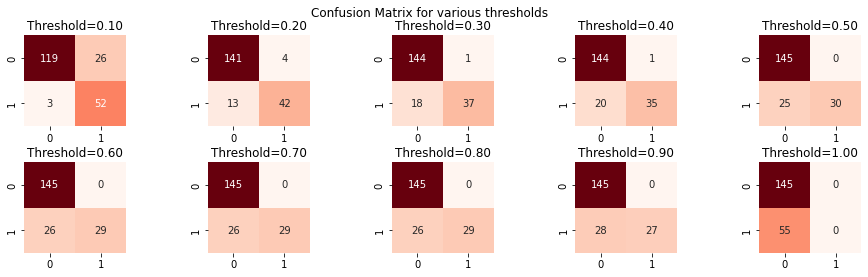

In [27]:
fig, axes = plt.subplots(2,5, figsize=(15,4))
     
for n, ax in enumerate(axes.flat):
    threshold =  (n+1)/10
    y_pred = (y_pred_prob > threshold).astype(int)
    cfm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cfm, annot=True, cmap="Reds", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("Threshold=%.2f" % threshold)
  
plt.subplots_adjust(hspace=0.4, wspace=0.8)
plt.suptitle("Confusion Matrix for various thresholds")

We might get better insigh on the optimal threshold by generation ROC Curve. It will plot the true positive (TP) vs. false positive (FP) rates at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve. Also, we calculate AUC which ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


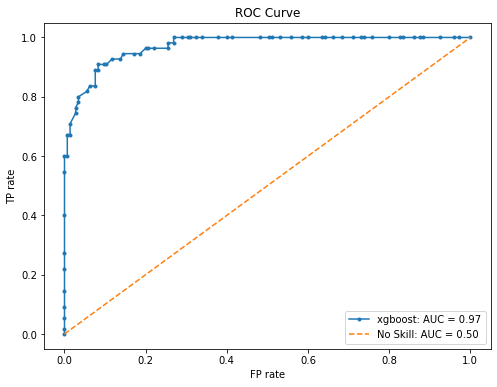

In [28]:
precision_recall_fscore_support(y_test.values, y_pred, average='weighted')
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_pred_prob)
auc = metrics.auc(fpr, tpr)
  
plt.figure(figsize=(8, 6))
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label="xgboost: AUC = %.2f" % auc)


# generate general prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
ns_auc = metrics.auc(ns_fpr, ns_tpr)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label="No Skill: AUC = %.2f" % ns_auc)

  
plt.ylabel("TP rate")
plt.xlabel("FP rate")
  
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

So, what is the optimal threshold? As mentioned depends on the business use-case, for example, if we consider the optimal threshold for our usecase is the one that has
highest TPR and minimum FPR, then we can calculate it as following:

In [29]:
print("Optimal threshold value is: %.3f" % thresholds[np.argmax(tpr - fpr)])

Optimal threshold value is: 0.150
